**Experiment Description:**   
- **Purpose:** Evaluate the impact of `multi step` and `two step` methods of chosing reliable negatives
- **Experimental Design:**
- PE Free: Set the proportion of type 1 inliers in training data as 0.1, 0.25 and 0.5, range the proportions of type 1 inliers in test data from 0.01 to 1, see the FDR and Power of these four methods using `multi step` or `two step`.
- PE methods: Range the proportions of type 1 inliers in test data from 0.01 to 1, see the FDR and Power of these four methods using `multi step` or `two step`.
- **Methods:** Proportion Estimation Free(PE Free); Classification, Mixture Model using Normal Fitting and Gamma Fitting
- **One-Class Classifier:** SVM (One Class)  
- **Binary Classifier:** SVM  
- **Data Shapes:** Uniform + Normal, with 50 dimensions
- **Size of Training Data:** 300 in total for PE free; and [50, 50] for PE methods
- **Size of Calibration Data:** [500, 500]
- **Size of Test Data:** 900 inliers and 100 outliers
  
- **Times of Iteration**: 10

Conclusion:
1. For methods without Proportion Estimation, 'multi-step' is better, especially the proportions of each type of inliers in training data is highly unequal to that in the unlabeled data.
2. For methods with Proportion Estimation(mixture model with normal/gamma fitting), 'two-step' is better.

Explanation:
When Proportions of each type of inliers in training data is highly unequal to that in the unlabeled data, OCC of 'two-step' method tends to learn the distributions of inliers wrongly, therefore detect more false negatives in the unlabeled data. And although the 'multi-step' could achieve the same in this case, applying OCC K times could certainly increase the deviation.

### Setup

In [453]:
# This helPE when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from statsmodels.stats.multitest import multipletests
import pomegranate
import torch
from pomegranate.distributions import *

np.set_printoptions(suppress=True)
%load_ext watermark
%watermark -m -n -p numpy,torch,pomegranate

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal
from mypackage.PUL import compute_pu_scores_neg,prepare_pu_score_matrices, compute_pu_scores_neg
from mypackage.MAMCOD_procedure import compute_MAMCOD_conformal_pv, compute_fdr_power, compute_standard_conformal_scores, train_occ, scale_data
from mypackage.proportion_estimation import adjust_proportions, compute_mean_distance, adjust_proportions_mixture_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy      : 1.26.4
torch      : 2.4.0
pomegranate: 1.1.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 80 Stepping 0, AuthenticAMD
CPU cores   : 16
Architecture: 64bit



## Data Generation

In [467]:
np.random.seed(0)

# Generate data
K = 2
dim = 50
means = [-1, 1]
radius = 4
a_signal = 4

# Training, Calibration, and Test data
num_in_train = 300
n_in_train = [250,250]
n_in_cal = [500, 500]
num_in_test = 900
n_in_test = [855, 45]
n_out_test = 100
n_test = sum(n_in_test) + n_out_test

# Range of rho values
rho_values_PEfree = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
rho_values_train = [0.1, 0.25, 0.5]

# Monte Carlo iterations
num_iterations = 10

## Preparation

In [468]:
# Define machine learning models
from sklearn.svm import SVC, OneClassSVM
from sklearn.ensemble import RandomForestClassifier, IsolationForest

# Define machine learning models
binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

In [469]:
# Store results
mean_fdr_PEfree = {rho_value_train: {step_method: [] for step_method in ['two_step','multi_step']} for rho_value_train in rho_values_train}
ci_fdr_PEfree = {rho_value_train: {step_method: [] for step_method in ['two_step','multi_step']} for rho_value_train in rho_values_train}
mean_power_PEfree = {rho_value_train: {step_method: [] for step_method in ['two_step','multi_step']} for rho_value_train in rho_values_train}
ci_power_PEfree = {rho_value_train: {step_method: [] for step_method in ['two_step','multi_step']} for rho_value_train in rho_values_train}
true_neg_rates_PEfree = {rho_value_train: {step_method: [] for step_method in ['two_step','multi_step']} for rho_value_train in rho_values_train}

### PU Learning

In [470]:
for rho_value_train in rho_values_train:
    # Train samples
    n_in_train = [int(rho_value_train * num_in_train)] + [(num_in_train - int(rho_value_train * num_in_train)) // (K - 1)] * (K - 1)
    
    # Adjust remaining train samples
    remaining_train_samples = num_in_train - sum(n_in_train)
    for i in range(remaining_train_samples):
        n_in_train[1 + i % (K - 1)] += 1
        
    for step_method in ['two_step','multi_step']:
        for rho in rho_values_PEfree:
            # Test samples
            n_in_test = [int(rho * num_in_test)] + [(num_in_test - int(rho * num_in_test)) // (K - 1)] * (K - 1)
            
            # Adjust remaining test samples
            remaining_test_samples = num_in_test - sum(n_in_test)
            for i in range(remaining_test_samples):
                n_in_test[1 + i % (K - 1)] += 1
        
            fdr_PE_free_vec = []
            power_PE_free_vec = []
            true_neg_vec = []

            for _ in range(num_iterations):
                # Generate initial training, calibration, and test data
                X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
                X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
                X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)
                Y_unlabeled = np.concatenate((Y_cal, Y_test))
    
                # Get a list of OCC
                X_train_scaled = scale_data(X_train, X_train)
                occ_list = train_occ(K, X_train_scaled, Y_train, oneclass_classifier)
        
                # Compute PU scores
                scores_cal_PE_free, scores_test_PE_free, neg_idx= compute_pu_scores_neg(
                    K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
                    occ_list, oneclass_classifier, step_method)
                
                # transform the format of scores
                scores_cal_mat_PE_free, scores_test_mat_PE_free = prepare_pu_score_matrices(
                    K, n_in_cal, n_test, scores_cal_PE_free, scores_test_PE_free)
                    
                # Compute MAMCOD conformal p-values
                MAMCOD_pv_PE_free = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_PE_free, scores_test_mat_PE_free, is_high_score_inlier = False)
                
                # Compute FDR and Power by BH procedure
                fdr_PE_free, power_PE_free = compute_fdr_power(MAMCOD_pv_PE_free, Y_test, alpha = 0.1)

                # Compute true negatives rates
                neg_rates = sum(Y_unlabeled[neg_idx] == 0)/ len(Y_unlabeled[neg_idx])
                
                true_neg_vec.append(neg_rates)
                fdr_PE_free_vec.append(fdr_PE_free)
                power_PE_free_vec.append(power_PE_free)

            # Calculate mean FDR and Power
            mean_fdr_PEfree[rho_value_train][step_method].append(np.mean(fdr_PE_free_vec))
            mean_power_PEfree[rho_value_train][step_method].append(np.mean(power_PE_free_vec))

            # Compute the standard deviation    
            ci_fdr_PEfree[rho_value_train][step_method].append((np.percentile(fdr_PE_free_vec, 5), np.percentile(fdr_PE_free_vec, 95)))
            ci_power_PEfree[rho_value_train][step_method].append((np.percentile(power_PE_free_vec, 5), np.percentile(power_PE_free_vec, 95)))

            # Compute the negatives rates
            true_neg_rates_PEfree[rho_value_train][step_method].append(np.mean(power_PE_free_vec))

### Plot

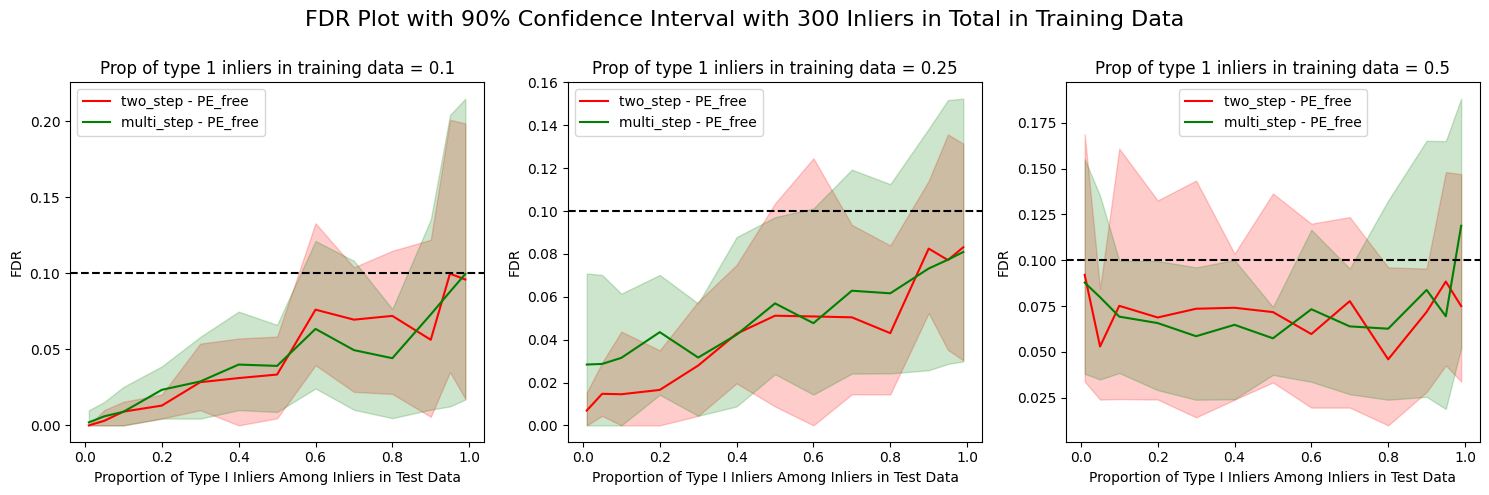

In [471]:
plt.figure(figsize=(15, 5))

for i, rho_value_train in enumerate(rho_values_train):
    plt.subplot(1, 3, i + 1)

    plt.plot(rho_values_PEfree, mean_fdr_PEfree[rho_value_train]['two_step'], label=f'two_step - PE_free', color='red', linestyle='-')
    plt.fill_between(rho_values, [ci[0] for ci in ci_fdr_PEfree[rho_value_train]['two_step']], [ci[1] for ci in ci_fdr_PEfree[rho_value_train]['two_step']], color='red', alpha=0.2)

    plt.plot(rho_values_PEfree, mean_fdr_PEfree[rho_value_train]['multi_step'], label=f'multi_step - PE_free', color='green', linestyle='-')
    plt.fill_between(rho_values, [ci[0] for ci in ci_fdr_PEfree[rho_value_train]['multi_step']], [ci[1] for ci in ci_fdr_PEfree[rho_value_train]['multi_step']], color='green', alpha=0.2)

    plt.axhline(y=0.1, color='k', linestyle='--')
    plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
    plt.ylabel('FDR')
    plt.title(f'Prop of type 1 inliers in training data = {rho_value_train}')
    plt.legend()

plt.suptitle('FDR Plot with 90% Confidence Interval with 300 Inliers in Total in Training Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

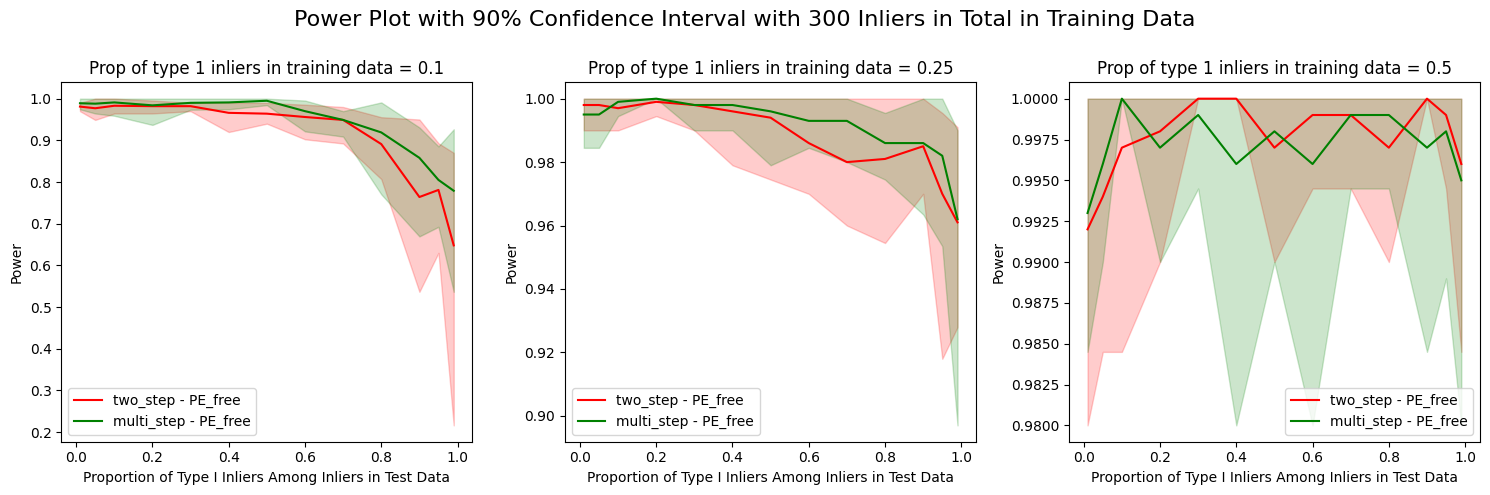

In [472]:
plt.figure(figsize=(15, 5))

for i, rho_value_train in enumerate(rho_values_train):
    plt.subplot(1, 3, i + 1)

    plt.plot(rho_values_PEfree, mean_power_PEfree[rho_value_train]['two_step'], label=f'two_step - PE_free', color='red', linestyle='-')
    plt.fill_between(rho_values, [ci[0] for ci in ci_power_PEfree[rho_value_train]['two_step']], [ci[1] for ci in ci_power_PEfree[rho_value_train]['two_step']], color='red', alpha=0.2)

    plt.plot(rho_values_PEfree, mean_power_PEfree[rho_value_train]['multi_step'], label=f'multi_step - PE_free', color='green', linestyle='-')
    plt.fill_between(rho_values, [ci[0] for ci in ci_power_PEfree[rho_value_train]['multi_step']], [ci[1] for ci in ci_power_PEfree[rho_value_train]['multi_step']], color='green', alpha=0.2)
    
    plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
    plt.ylabel('Power')
    plt.title(f'Prop of type 1 inliers in training data = {rho_value_train}')
    plt.legend()

plt.suptitle('Power Plot with 90% Confidence Interval with 300 Inliers in Total in Training Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

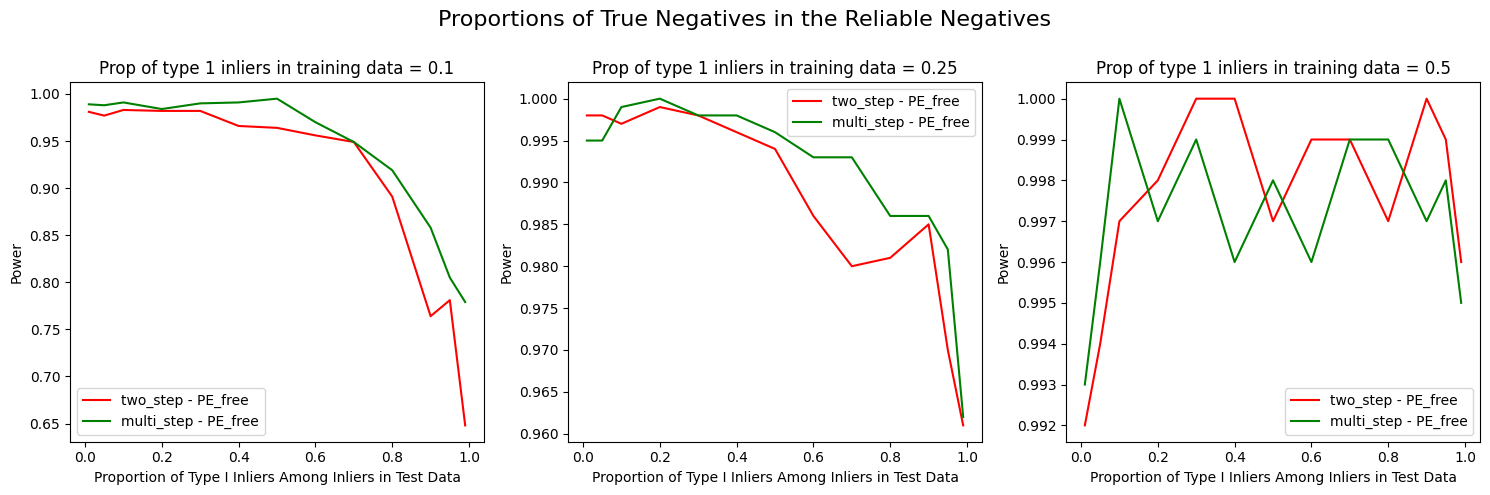

In [473]:
plt.figure(figsize=(15, 5))

for i, rho_value_train in enumerate(rho_values_train):
    plt.subplot(1, 3, i + 1)

    plt.plot(rho_values_PEfree, true_neg_rates_PEfree[rho_value_train]['two_step'], label=f'two_step - PE_free', color='red', linestyle='-')
    plt.plot(rho_values_PEfree, true_neg_rates_PEfree[rho_value_train]['multi_step'], label=f'multi_step - PE_free', color='green', linestyle='-')
    
    plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
    plt.ylabel('Power')
    plt.title(f'Prop of type 1 inliers in training data = {rho_value_train}')
    plt.legend()

plt.suptitle('Proportions of True Negatives in the Reliable Negatives', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## Methods of Classification, Normal fitting, Gamma fitting

In [481]:
# Training, Calibration, and Test data
n_in_train = [50,50]

# Range of rho values
rho_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# Monte Carlo iterations
num_iterations = 10

In [482]:
# Store results
mean_fdr ={step_method: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for step_method in ['two_step','multi_step']}
ci_fdr ={step_method: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for step_method in ['two_step','multi_step']} 
mean_power ={step_method: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for step_method in ['two_step','multi_step']}
ci_power = {step_method: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for step_method in ['two_step','multi_step']}

true_neg_rates = {step_method: {'PE_free': [], 'classification': [], 'normal': [], 'gamma': []} for step_method in ['two_step','multi_step']}

In [483]:
for step_method in ['two_step','multi_step']:
    for rho in rho_values:
        # Test samples
        n_in_test = [int(rho * num_in_test)] + [(num_in_test - int(rho * num_in_test)) // (K - 1)] * (K - 1)
        
        # Adjust remaining test samples
        remaining_test_samples = num_in_test - sum(n_in_test)
        for i in range(remaining_test_samples):
            n_in_test[1 + i % (K - 1)] += 1
    
        fdr_classification_vec = []
        fdr_normal_vec = []
        fdr_gamma_vec = []
        power_classification_vec = []
        power_normal_vec = []
        power_gamma_vec = []
        true_neg_class_vec = []
        true_neg_normal_vec = []
        true_neg_gamma_vec = []
    
        for _ in range(num_iterations):
            # Generate initial training, calibration, and test data
            X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
            X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
            X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)
            Y_unlabeled = np.concatenate((Y_cal, Y_test))

            # Get a list of OCC
            X_train_scaled = scale_data(X_train, X_train)
            occ_list = train_occ(K, X_train_scaled, Y_train, oneclass_classifier)
    
            # Adjust the proportions in the training data
            X_train_classification, Y_train_classification = adjust_proportions(K, X_train, Y_train, X_cal, X_test, occ_list, method='subsample')
            X_train_normal, Y_train_normal  = adjust_proportions_mixture_model(K, X_train, Y_train, X_cal, X_test, occ_list, sample_method='subsample', mixture_distributions = 'normal')
            X_train_gamma, Y_train_gamma = adjust_proportions_mixture_model(K, X_train, Y_train, X_cal, X_test, occ_list, sample_method='subsample', mixture_distributions = 'gamma')
    
            # Compute PU scores
            scores_cal_classification, scores_test_classification, neg_rates_class = compute_pu_scores_neg(
                K, X_train_classification, Y_train_classification, X_cal, Y_cal, X_test, binary_classifier,
                occ_list, oneclass_classifier, step_method)
            
            scores_cal_normal, scores_test_normal, neg_rates_normal = compute_pu_scores_neg(
                K, X_train_normal, Y_train_normal, X_cal, Y_cal, X_test, binary_classifier,
                occ_list, oneclass_classifier, step_method)
            
            scores_cal_gamma, scores_test_gamma, neg_rates_gamma = compute_pu_scores_neg(
                K, X_train_gamma, Y_train_gamma, X_cal, Y_cal, X_test, binary_classifier,
                occ_list, oneclass_classifier, step_method)

            # transform the format of scores            
            scores_cal_mat_classification, scores_test_mat_classification = prepare_pu_score_matrices(
                K, n_in_cal, n_test, scores_cal_classification, scores_test_classification)
            
            scores_cal_mat_normal, scores_test_mat_normal = prepare_pu_score_matrices(
                K, n_in_cal, n_test, scores_cal_normal, scores_test_normal)
            
            scores_cal_mat_gamma, scores_test_mat_gamma = prepare_pu_score_matrices(
                K, n_in_cal, n_test, scores_cal_gamma, scores_test_gamma)
    
            # Compute MAMCOD conformal p-values
            MAMCOD_pv_classification = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_classification, scores_test_mat_classification, is_high_score_inlier = False)
            MAMCOD_pv_normal = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_normal, scores_test_mat_normal, is_high_score_inlier = False)
            MAMCOD_pv_gamma = compute_MAMCOD_conformal_pv(K, n_in_cal, scores_cal_mat_gamma, scores_test_mat_gamma, is_high_score_inlier = False)
            
            # Compute FDR and Power by BH procedure
            fdr_classification, power_classification = compute_fdr_power(MAMCOD_pv_classification, Y_test, alpha = 0.1)
            fdr_normal, power_normal = compute_fdr_power(MAMCOD_pv_normal, Y_test, alpha = 0.1)
            fdr_gamma, power_gamma = compute_fdr_power(MAMCOD_pv_gamma, Y_test, alpha = 0.1)

            # Compute true negatives rates

            neg_rates_class = sum(Y_unlabeled[neg_rates_class] == 0)/ len(Y_unlabeled[neg_rates_class])
            neg_rates_normal = sum(Y_unlabeled[neg_rates_normal] == 0)/ len(Y_unlabeled[neg_rates_normal])
            neg_rates_gamma = sum(Y_unlabeled[neg_rates_gamma] == 0)/ len(Y_unlabeled[neg_rates_gamma])

            true_neg_class_vec.append(neg_rates_class)
            true_neg_normal_vec.append(neg_rates_normal)
            true_neg_gamma_vec.append(neg_rates_gamma)
            
            fdr_classification_vec.append(fdr_classification)
            fdr_normal_vec.append(fdr_normal)
            fdr_gamma_vec.append(fdr_gamma)
            power_classification_vec.append(power_classification)
            power_normal_vec.append(power_normal)
            power_gamma_vec.append(power_gamma)    

        # Calculate mean FDR and Power
        mean_fdr[step_method]['classification'].append(np.mean(fdr_classification_vec))
        mean_fdr[step_method]['normal'].append(np.mean(fdr_normal_vec))
        mean_fdr[step_method]['gamma'].append(np.mean(fdr_gamma_vec))
    
        mean_power[step_method]['classification'].append(np.mean(power_classification_vec))
        mean_power[step_method]['normal'].append(np.mean(power_normal_vec))
        mean_power[step_method]['gamma'].append(np.mean(power_gamma_vec))
    
        # Compute the standard deviation    
        ci_fdr[step_method]['classification'].append((np.percentile(fdr_classification_vec, 5), np.percentile(fdr_classification_vec, 95)))
        ci_fdr[step_method]['normal'].append((np.percentile(fdr_normal_vec, 5), np.percentile(fdr_normal_vec, 95)))
        ci_fdr[step_method]['gamma'].append((np.percentile(fdr_gamma_vec, 5), np.percentile(fdr_gamma_vec, 95)))
        
        ci_power[step_method]['classification'].append((np.percentile(power_classification_vec, 5), np.percentile(power_classification_vec, 95)))
        ci_power[step_method]['normal'].append((np.percentile(power_normal_vec, 5), np.percentile(power_normal_vec, 95)))
        ci_power[step_method]['gamma'].append((np.percentile(power_gamma_vec, 5), np.percentile(power_gamma_vec, 95)))

        # Compute the negatives rates
        true_neg_rates[step_method]['classification'].append(np.mean(true_neg_class_vec))
        true_neg_rates[step_method]['normal'].append(np.mean(true_neg_normal_vec))
        true_neg_rates[step_method]['gamma'].append(np.mean(neg_rates_gamma))

### Plot

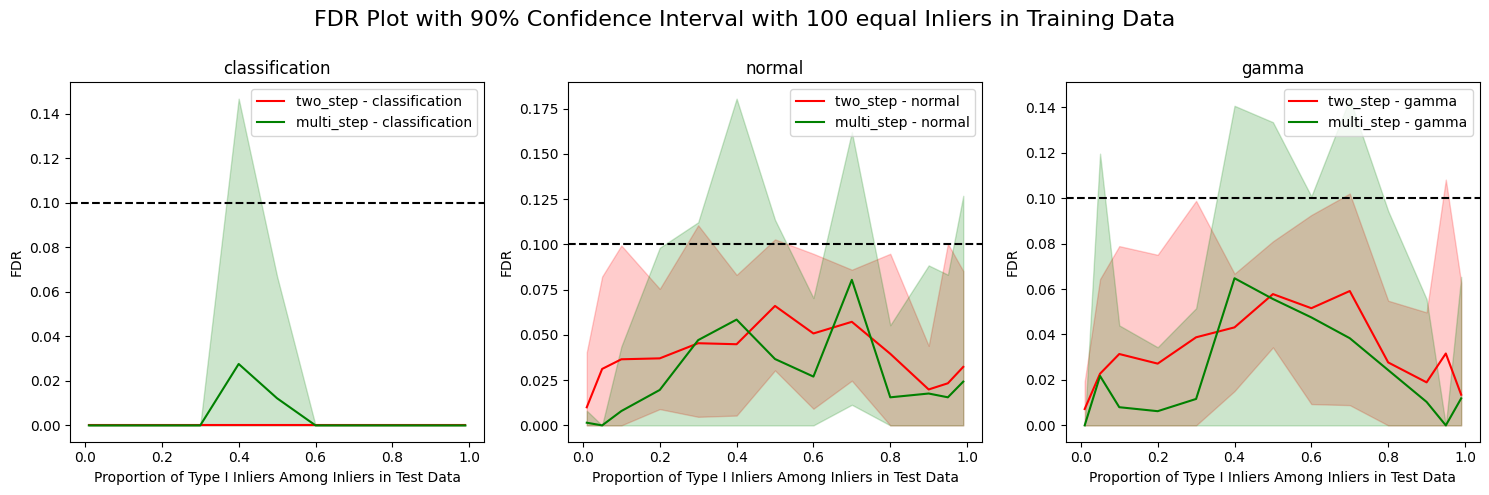

In [484]:
# Create a 1x3 grid of subplots
plt.figure(figsize=(15, 5))

metrics = ['classification', 'normal', 'gamma']
for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(rho_values, mean_fdr['two_step'][metric], label=f'two_step - {metric}', color='red', linestyle='-')
        plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['two_step'][metric]], [ci[1] for ci in ci_fdr['two_step'][metric]], color='red', alpha=0.2)

        plt.plot(rho_values, mean_fdr['multi_step'][metric], label=f'multi_step - {metric}', color='green', linestyle='-')
        plt.fill_between(rho_values, [ci[0] for ci in ci_fdr['multi_step'][metric]], [ci[1] for ci in ci_fdr['multi_step'][metric]], color='green', alpha=0.2)

        plt.axhline(y=0.1, color='k', linestyle='--')
        plt.title(f'{metric}')
        plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
        plt.ylabel('FDR')
        plt.legend()

plt.suptitle('FDR Plot with 90% Confidence Interval with 100 equal Inliers in Training Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

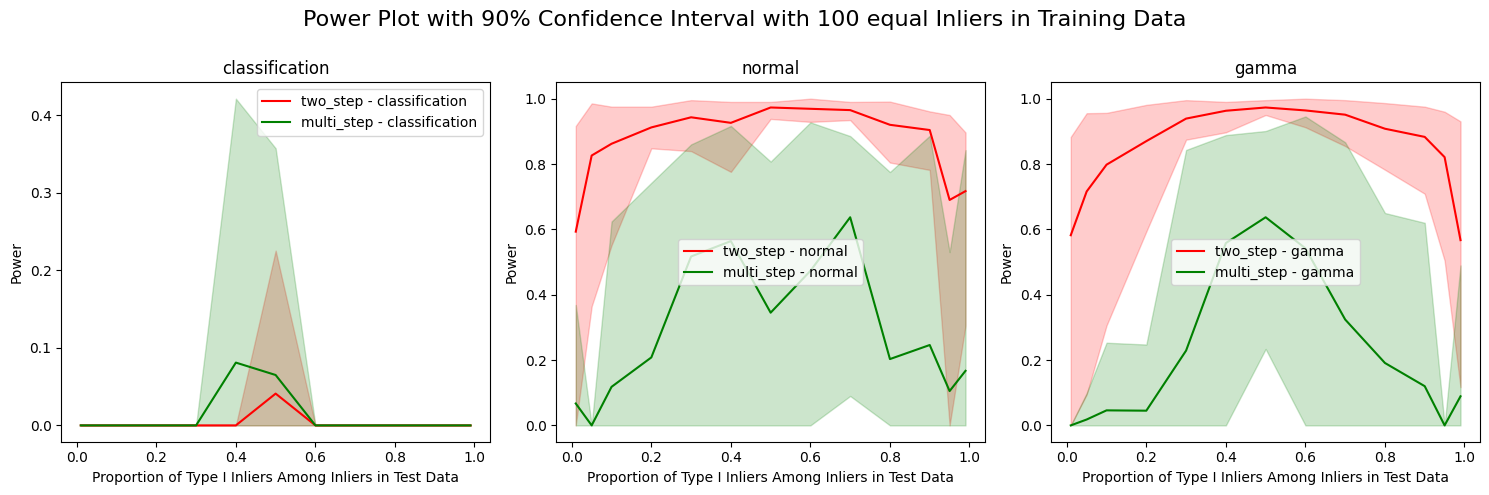

In [485]:
# Create a 1x3 grid of subplots
plt.figure(figsize=(15, 5))

metrics = ['classification', 'normal', 'gamma']
for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(rho_values, mean_power['two_step'][metric], label=f'two_step - {metric}', color='red', linestyle='-')
        plt.fill_between(rho_values, [ci[0] for ci in ci_power['two_step'][metric]], [ci[1] for ci in ci_power['two_step'][metric]], color='red', alpha=0.2)

        plt.plot(rho_values, mean_power['multi_step'][metric], label=f'multi_step - {metric}', color='green', linestyle='-')
        plt.fill_between(rho_values, [ci[0] for ci in ci_power['multi_step'][metric]], [ci[1] for ci in ci_power['multi_step'][metric]], color='green', alpha=0.2)

        plt.title(f'{metric}')
        plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
        plt.ylabel('Power')
        plt.legend()

plt.suptitle('Power Plot with 90% Confidence Interval with 100 equal Inliers in Training Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

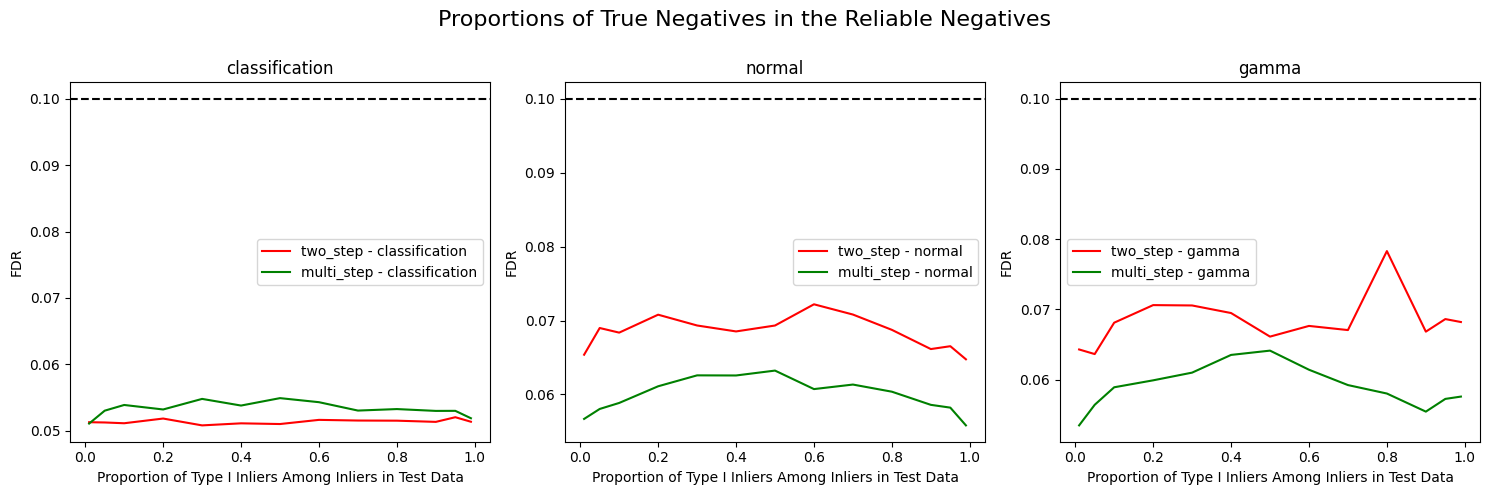

In [486]:
# Create a 1x3 grid of subplots
plt.figure(figsize=(15, 5))

metrics = ['classification', 'normal', 'gamma']
for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.plot(rho_values, true_neg_rates['two_step'][metric], label=f'two_step - {metric}', color='red', linestyle='-')
        plt.plot(rho_values, true_neg_rates['multi_step'][metric], label=f'multi_step - {metric}', color='green', linestyle='-')

        plt.axhline(y=0.1, color='k', linestyle='--')
        plt.title(f'{metric}')
        plt.xlabel('Proportion of Type I Inliers Among Inliers in Test Data')
        plt.ylabel('FDR')
        plt.legend()

plt.suptitle('Proportions of True Negatives in the Reliable Negatives', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Experiment Description:**   
- **Purpose:** Evaluate the impact of `multi step` and `two step` methods of chosing reliable negatives
- **Experimental Design:**
- PE Free: Set the proportion of type 1 inliers in training data as 0.1, 0.25 and 0.5, range the proportions of type 1 inliers in test data from 0.01 to 1, see the FDR and Power of these four methods using `multi step` or `two step`.
- PE methods: Range the proportions of type 1 inliers in test data from 0.01 to 1, see the FDR and Power of these four methods using `multi step` or `two step`.
- **Methods:** Proportion Estimation Free(PE Free); Classification, Mixture Model using Normal Fitting and Gamma Fitting
- **One-Class Classifier:** SVM (One Class)  
- **Binary Classifier:** SVM  
- **Data Shapes:** Uniform + Normal, with 50 dimensions
- **Size of Training Data:** 300 in total for PE free; and [50, 50] for PE methods
- **Size of Calibration Data:** [500, 500]
- **Size of Test Data:** 900 inliers and 100 outliers
  
- **Times of Iteration**: 10

Conclusion:
1. For methods without Proportion Estimation, 'multi-step' is better, especially the proportions of each type of inliers in training data is highly unequal to that in the unlabeled data.
2. For methods with Proportion Estimation(mixture model with normal/gamma fitting), 'two-step' is better.

Explanation:
When Proportions of each type of inliers in training data is highly unequal to that in the unlabeled data, OCC of 'two-step' method tends to learn the distributions of inliers wrongly, therefore detect more false negatives in the unlabeled data. And although the 'multi-step' could achieve the same in this case, applying OCC K times could certainly increase the deviation.